In [2]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import ujson as json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import * 
from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs

In [3]:
methods = {
    "bald": bald,
    "var_ratio": var_ratio,
    "entropy": mean_entropy,
    "sampled_max_prob": sampled_max_prob,
    "variance": probability_variance,
}

# ROSTD with DPP

bald: 0.9778332137447182
var_ratio: 0.824809216295942
entropy: 0.9762986526349359
sampled_max_prob: 0.9745931595312125
variance: 0.9744147333173881
max_prob: 0.9678525073746314


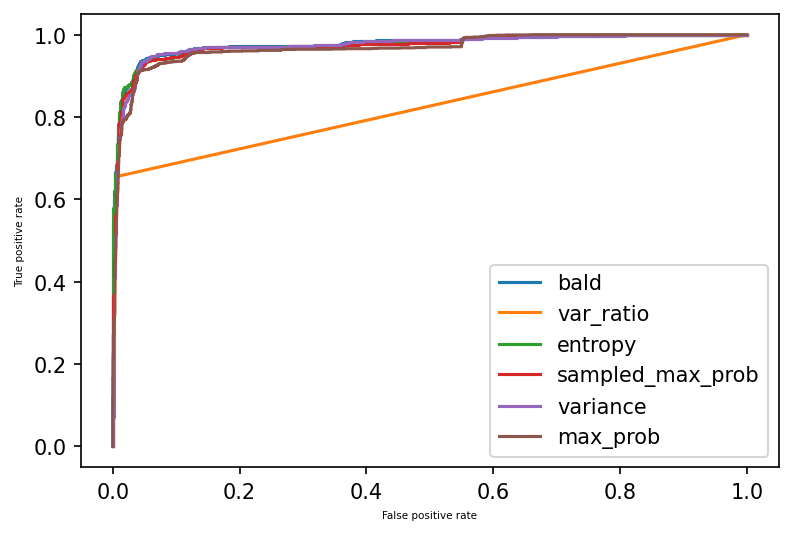

In [4]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/rostd/DPP_last/0.0/2021-08-30/09-22-51-rep0'
#res_path = '../workdir/results/oos_test/rostd/DPP/google/electra-base-discriminator/32/4/101/42'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
          
probabilities = np.asarray(model_outputs['probabilities'])
sampled_probabilities = np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2)

predictions = np.argmax(probabilities, axis=-1)
labels = (np.asarray(model_outputs['true_labels']) == 12).astype("uint8")

predictions = np.argmax(probabilities, axis=-1)
errors = labels#(labels != predictions).astype("uint8")

plt.figure(dpi=150)
auc = []

for name, method_function in methods.items():
    ue_scores = method_function(sampled_probabilities)
    fpr, tpr, _ = roc_curve(errors, ue_scores)

    plt.plot(fpr, tpr, label=name)
    print(f"{name}:", roc_auc_score(errors, ue_scores))
    auc.append(roc_auc_score(errors, ue_scores))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(errors, max_prob)
print(f"max_prob:", roc_auc_score(errors, max_prob))
auc.append(roc_auc_score(errors, max_prob))

plt.plot(fpr, tpr, label="max_prob")
plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

# ROSTD with Maha

Mahalanobis: 0.9959997582481852
Mahalanobis fixed: 0.9938634830505324
max_prob: 0.928086999871241


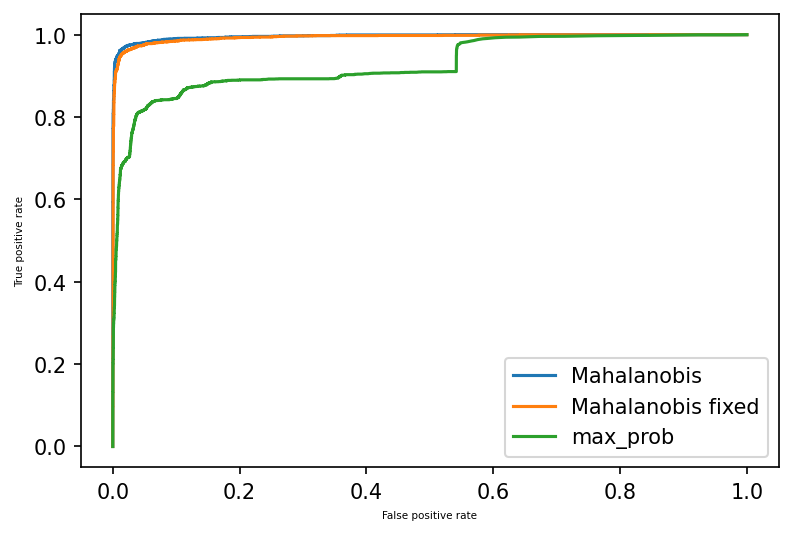

In [4]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/rostd/maha_last/0.0/2021-08-30/09-00-32-rep0'
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/rostd/maha_last/0.0/2021-09-10/16-21-07-0'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
          
mahalanobis_distance_fixed = np.asarray(model_outputs['mahalanobis_distance_fixed'])
mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
probabilities = np.asarray(model_outputs['probabilities'])
eval_labels = np.asarray(model_outputs['eval_labels'])

plt.figure(dpi=150)
label = (eval_labels == 12).astype('uint8')
fpr, tpr, _ = roc_curve(label, mahalanobis_distance)
plt.plot(fpr, tpr, label="Mahalanobis")
print(f"Mahalanobis:", roc_auc_score(label, mahalanobis_distance))

fpr, tpr, _ = roc_curve(label, mahalanobis_distance_fixed)
plt.plot(fpr, tpr, label="Mahalanobis fixed")
print(f"Mahalanobis fixed:", roc_auc_score(label, mahalanobis_distance_fixed))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(label, max_prob)
plt.plot(fpr, tpr, label="max_prob")
print(f"max_prob:", roc_auc_score(label, max_prob))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

# ROSTD with NUQ

NUQ epistemic: 0.9898359879109078
NUQ aleatoric: 0.9870306720737989
NUQ total: 0.9887498315432813


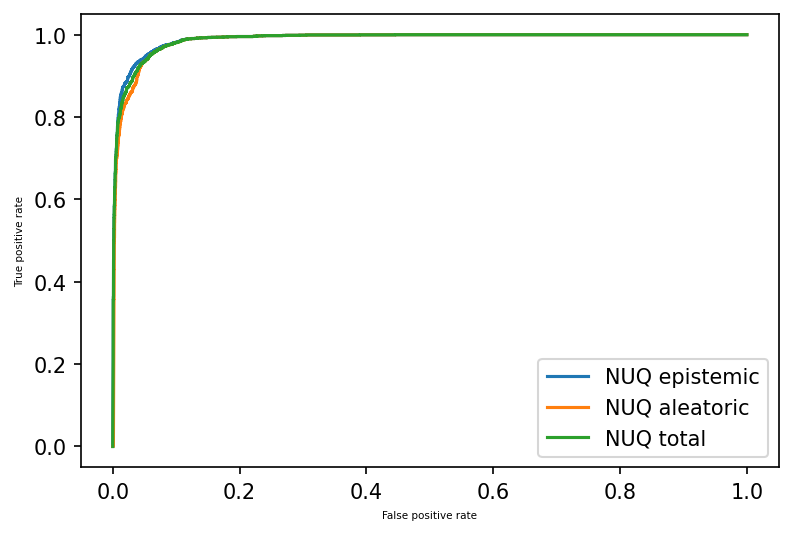

In [94]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/oos_test/rostd/nuq/google/electra-base-discriminator/32/4/101/17'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
          
eval_labels = np.asarray(model_outputs['eval_labels'])

plt.figure(dpi=150)
label = (eval_labels == 12).astype('uint8')

for ue_col in ['epistemic','aleatoric', 'total']:
    ue_scores = np.asarray(model_outputs[ue_col])
    fpr, tpr, _ = roc_curve(label, ue_scores)
    print(f"NUQ {ue_col}:", roc_auc_score(label, ue_scores))
    plt.plot(fpr, tpr, label=f"NUQ {ue_col}")

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

# Mahalanobis SNIPS

Mahalanobis: 0.9510330806449071
Mahalanobis fixed: 0.6735906447494917
max_prob: 0.843816488313817
Mahalanobis: 0.9976109491415615
Mahalanobis fixed: 0.8637431162941368
max_prob: 0.9651158082280531
Mahalanobis: 0.9363522089707821
Mahalanobis fixed: 0.8786215777048777
max_prob: 0.7826389101797632
Mahalanobis: 0.9995351830663616
Mahalanobis fixed: 0.7440646453089245
max_prob: 0.9942612986270023
Mahalanobis: 0.9710829597087233
Mahalanobis fixed: 0.9410224776577498
max_prob: 0.9277826257033671
Mean max_prob: 0.9027230262104006
Mean Mahalanobis: 0.9711228763064671
Mean Mahalanobis fixed: 0.820208492343036


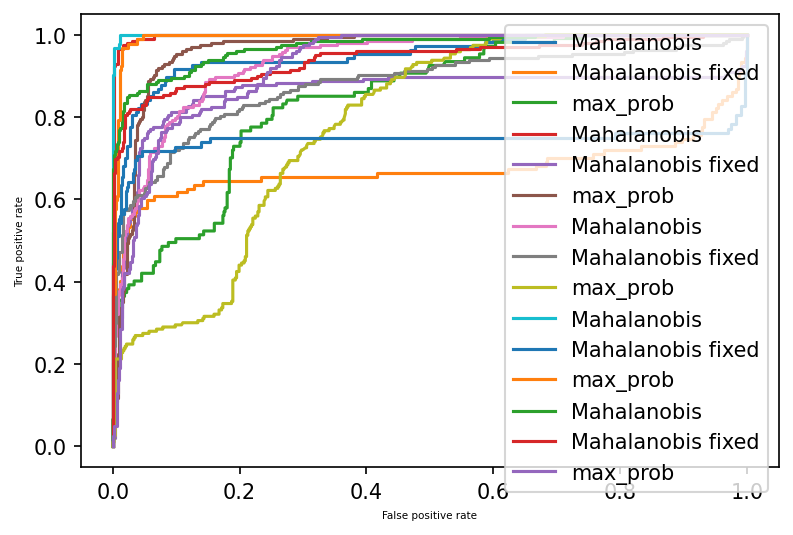

In [20]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/snips/maha_last/0.05/2021-09-10/18-40-56-0'
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/snips/maha_last/0.0/2021-09-10/18-47-30-0'
msp = []
maha = []
maha_f = []
plt.figure(dpi=150)
    
for i in range(5):

    with open(Path(res_path) / f'dev_inference{i}.json') as f:
            model_outputs = json.loads(f.read())

    probabilities = np.asarray(model_outputs['probabilities'])
    mahalanobis_distance_fixed = np.asarray(model_outputs['mahalanobis_distance_fixed'])
    mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
    eval_labels = np.asarray(model_outputs['eval_labels'])

    label = (eval_labels == np.max(eval_labels)).astype('uint8')
    fpr, tpr, _ = roc_curve(label, mahalanobis_distance)
    plt.plot(fpr, tpr, label="Mahalanobis")
    print(f"Mahalanobis:", roc_auc_score(label, mahalanobis_distance))

    fpr, tpr, _ = roc_curve(label, mahalanobis_distance_fixed)
    plt.plot(fpr, tpr, label="Mahalanobis fixed")
    print(f"Mahalanobis fixed:", roc_auc_score(label, mahalanobis_distance_fixed))

    max_prob = 1 - np.max(probabilities, axis=-1)
    fpr, tpr, _ = roc_curve(label, max_prob)
    plt.plot(fpr, tpr, label="max_prob")
    print(f"max_prob:", roc_auc_score(label, max_prob))
    msp.append(roc_auc_score(label, max_prob))
    maha.append(roc_auc_score(label, mahalanobis_distance))
    maha_f.append(roc_auc_score(label, mahalanobis_distance_fixed))

print(f"Mean max_prob:", np.mean(msp))
print(f"Mean Mahalanobis:", np.mean(maha))
print(f"Mean Mahalanobis fixed:", np.mean(maha_f))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

# NUQ SNIPS

NUQ epistemic: 0.9534443901593356
NUQ aleatoric: 0.9488030133488835
NUQ total: 0.9512064427668595
NUQ epistemic: 0.9616638321995464
NUQ aleatoric: 0.9514901198574668
NUQ total: 0.9587483803045027
NUQ epistemic: 0.9208694852377595
NUQ aleatoric: 0.9189992948462459
NUQ total: 0.9202665276798399
NUQ epistemic: 0.9903282322654462
NUQ aleatoric: 0.9861806350114416
NUQ total: 0.9897382723112128
NUQ epistemic: 0.9550346543094715
NUQ aleatoric: 0.95410184655814
NUQ total: 0.954874171255479
NUQ mean epistemic: 0.9562681188343118
NUQ mean aleatoric: 0.9519149819244357
NUQ mean total: 0.9549667588635788


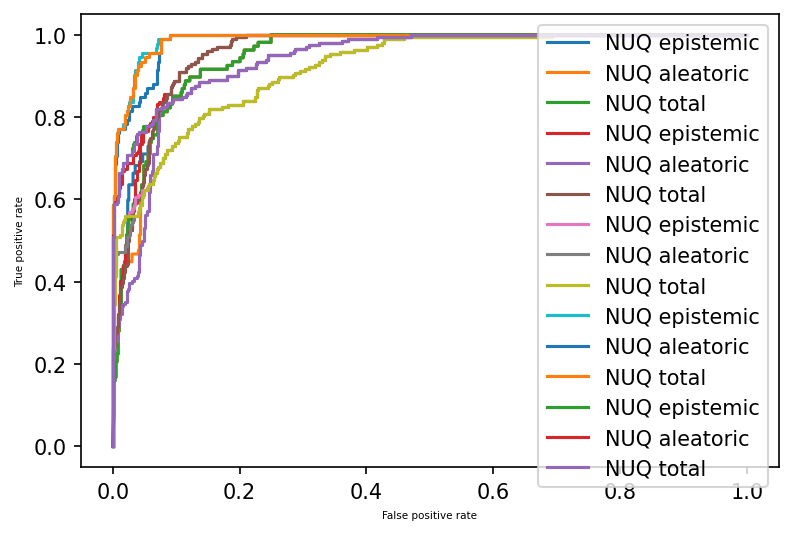

In [6]:
plt.figure(dpi=150)
epistemic = []
aleatoric = []
total = []
for i in range(5):
    res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/oos_test_sn/snips/nuq/google/electra-base-discriminator/16/128/1e-05/101/17'
    with open(Path(res_path) / f'dev_inference{i}.json') as f:
            model_outputs = json.loads(f.read())

    eval_labels = np.asarray(model_outputs['eval_labels'])
    
    label = (eval_labels == np.max(eval_labels)).astype('uint8')

    for ue_col in ['epistemic','aleatoric', 'total']:
        ue_scores = np.asarray(model_outputs[ue_col])
        fpr, tpr, _ = roc_curve(label, ue_scores)
        print(f"NUQ {ue_col}:", roc_auc_score(label, ue_scores))
        plt.plot(fpr, tpr, label=f"NUQ {ue_col}")
        if ue_col == 'epistemic':
            epistemic.append(roc_auc_score(label, ue_scores))
        if ue_col == 'aleatoric':
            aleatoric.append(roc_auc_score(label, ue_scores))
        if ue_col == 'total':
            total.append(roc_auc_score(label, ue_scores))

print(f"NUQ mean epistemic:", np.mean(epistemic))
print(f"NUQ mean aleatoric:", np.mean(aleatoric))
print(f"NUQ mean total:", np.mean(total))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

# SNGP

bald: 0.96496
var_ratio: 0.9217766666666667
entropy: 0.18852999999999998
sampled_max_prob: 0.9133066666666666
variance: 0.9643566666666665
max_prob: 0.9225333333333333
SNGP: 0.9689566666666667


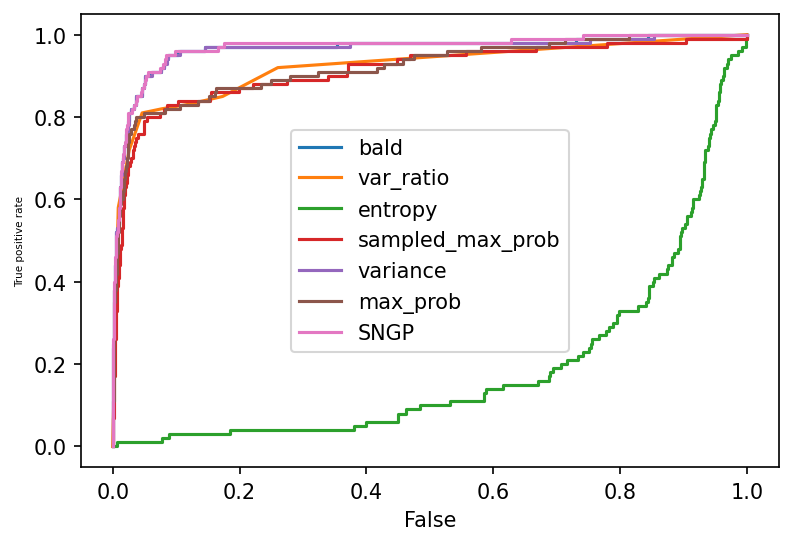

In [3]:
res_path = '../workdir/results/sngp_oos/clinc_oos/SNGP/google/electra-base-discriminator/16/101/51'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
        
probabilities = np.asarray(model_outputs['probabilities'])
sampled_probabilities = np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2)

predictions = np.argmax(probabilities, axis=-1)
labels = (np.asarray(model_outputs['true_labels']) == 42).astype("uint8")

predictions = np.argmax(probabilities, axis=-1)
errors = labels

plt.figure(dpi=150)
auc = []

for name, method_function in methods.items():
    ue_scores = method_function(sampled_probabilities)
    fpr, tpr, _ = roc_curve(errors, ue_scores)

    plt.plot(fpr, tpr, label=name)
    print(f"{name}:", roc_auc_score(errors, ue_scores))
    auc.append(roc_auc_score(errors, ue_scores))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(errors, max_prob)
print(f"max_prob:", roc_auc_score(errors, max_prob))
auc.append(roc_auc_score(errors, max_prob))
plt.plot(fpr, tpr, label="max_prob")

SNGP_stds = np.asarray(model_outputs['stds'])
ue_scores = SNGP_stds.mean(-1)
fpr, tpr, _ = roc_curve(errors, ue_scores)
plt.plot(fpr, tpr, label="SNGP")
print(f"SNGP:", roc_auc_score(errors, ue_scores))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False")
plt.legend()

In [4]:
sngp = SNGP_stds.mean(-1)

# DPP

In [100]:
!ls /mnt/users/avazhentsev/uncertainty-estimation-test/workdir/results/clinc_oos/DPP_last/0.0/2021-08-26/19-52-22-0
#electra tuned

!ls /mnt/users/avazhentsev/uncertainty-estimation-test/workdir/results/clinc_oos/DPP_last/0.0/2021-08-27/08-22-41-0
#roberta tuned

config.json	    run_oos.log		     tokenizer_config.json  vocab.txt
dev_inference.json  special_tokens_map.json  training_args.bin
pytorch_model.bin   tokenizer.json	     training_indexes.pkl
run_oos.log  training_indexes.pkl


In [106]:
!ls /mnt/users/avazhentsev/uncertainty-estimation-params/workdir/results/clinc_oos/DPP_last/0.0/2021-08-27/11-54-53-0
#roberta, val

!ls /mnt/users/avazhentsev/uncertainty-estimation-params/workdir/results/clinc_oos/DPP_last/0.0/2021-08-27/12-25-41-0
#roberta, test

config.json	    run_oos.log		     training_args.bin
dev_inference.json  special_tokens_map.json  training_indexes.pkl
merges.txt	    tokenizer.json	     vocab.json
pytorch_model.bin   tokenizer_config.json
config.json	    run_oos.log		     training_args.bin
dev_inference.json  special_tokens_map.json  training_indexes.pkl
merges.txt	    tokenizer.json	     vocab.json
pytorch_model.bin   tokenizer_config.json


bald: 0.970258
AUPRC bald: 0.9019137509551769
var_ratio: 0.9002632222222221
AUPRC var_ratio: 0.8411768494383037
entropy: 0.9755648888888888
AUPRC entropy: 0.9250458460415367
sampled_max_prob: 0.9735524444444444
AUPRC sampled_max_prob: 0.9147937941226003
variance: 0.467536
AUPRC variance: 0.23523233185916456
max_prob: 0.9739355555555554
AUPRC max_prob: 0.9077334559775975


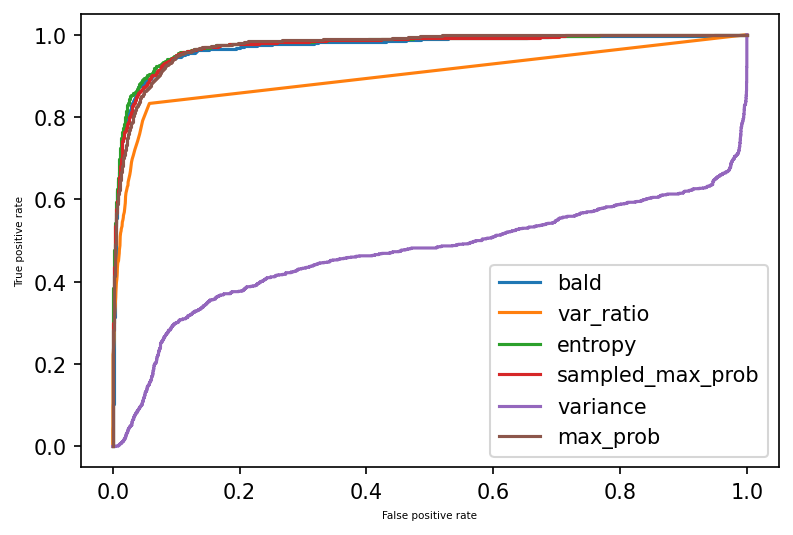

In [4]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/clinc_oos/DPP_last/0.0/2021-08-19/17-12-17-0'
res_path = '../workdir/results/oos_test/clinc_oos/DPP/roberta-large/32/10/101/17'
res_path = '/mnt/users/avazhentsev/uncertainty-estimation-params/workdir/results/oos_test/clinc_oos/DPP/roberta-large/16/4/101/42'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
          
probabilities = np.asarray(model_outputs['probabilities'])
sampled_probabilities = np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2)

predictions = np.argmax(probabilities, axis=-1)
labels = (np.asarray(model_outputs['true_labels']) == 42).astype("uint8")

predictions = np.argmax(probabilities, axis=-1)
errors = labels#(labels != predictions).astype("uint8")

plt.figure(dpi=150)
aucs = []

for name, method_function in methods.items():
    ue_scores = method_function(sampled_probabilities)
    fpr, tpr, _ = roc_curve(errors, ue_scores)

    plt.plot(fpr, tpr, label=name)
    print(f"{name}:", roc_auc_score(errors, ue_scores))
    
    precision, recall, _ = precision_recall_curve(errors, ue_scores)
    print(f"AUPRC {name}:", auc(recall, precision))
    aucs.append(roc_auc_score(errors, ue_scores))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(errors, max_prob)
print(f"max_prob:", roc_auc_score(errors, max_prob))

precision, recall, _ = precision_recall_curve(errors, max_prob)
print(f"AUPRC max_prob:", auc(recall, precision))
aucs.append(roc_auc_score(errors, max_prob))

plt.plot(fpr, tpr, label="max_prob")
plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

In [6]:
dpp = bald(sampled_probabilities)

# NUQ (by Maxim Panov)

NUQ epistemic: 0.9526937777777778
NUQ aleatoric: 0.9516446666666667
NUQ total: 0.9523984444444444


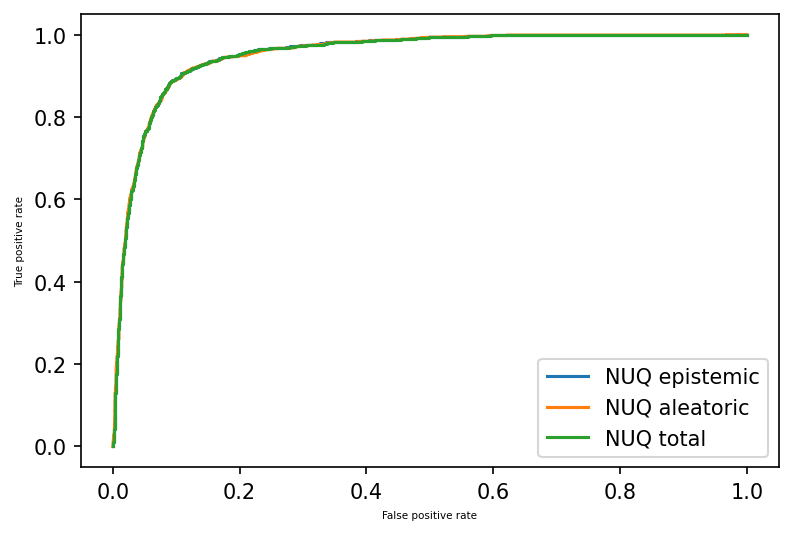

In [3]:
res_path = '../workdir/results/oos_test/clinc_oos/nuq/google/electra-base-discriminator/32/10/101/42'
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/oos_test_sn_all/clinc_oos/nuq/5e-05/8/101/17'

with open(Path(res_path) / 'dev_inference.json') as f:
    model_outputs = json.load(f)
    
plt.figure(dpi=150)

#errors = np.asarray(model_outputs['out_of_scope_label'])
errors = (np.asarray(model_outputs['eval_labels']) == 42).astype("uint8")

for ue_col in ['epistemic','aleatoric', 'total']:
    ue_scores = np.asarray(model_outputs[ue_col])
    fpr, tpr, _ = roc_curve(errors, ue_scores)
    print(f"NUQ {ue_col}:", roc_auc_score(errors, ue_scores))
    plt.plot(fpr, tpr, label=f"NUQ {ue_col}")

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

In [18]:
nuq = np.asarray(model_outputs['epistemic'])

Mahalanobis: 0.9850577777777777
Mahalanobis fixed: 0.9811326666666667
max_prob: 0.9701076666666667


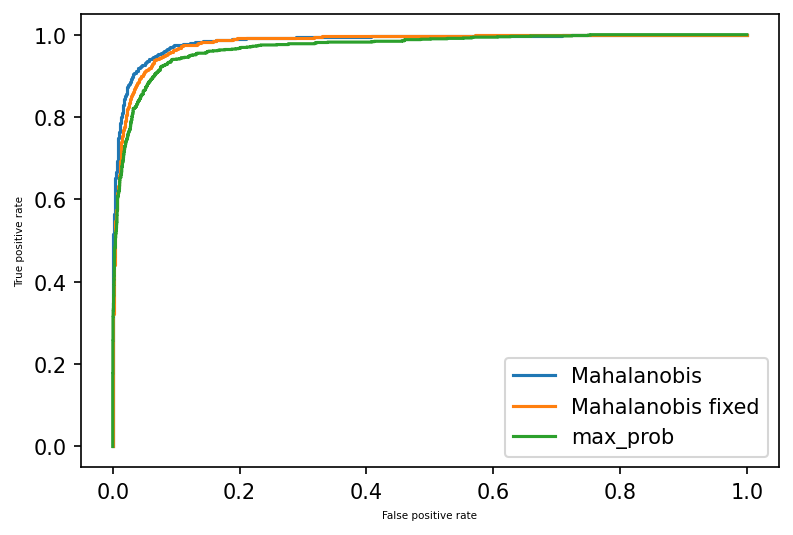

In [6]:
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/clinc_oos/maha_last/0.0/2021-09-10/15-00-56-0'
res_path = '/mnt/users/avazhentsev/uncertainty-estimation/workdir/results/clinc_oos/maha_last/0.0/2021-09-10/16-21-16-0'

with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
          
mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
mahalanobis_distance_fixed = np.asarray(model_outputs['mahalanobis_distance_fixed'])
eval_labels = np.asarray(model_outputs['eval_labels'])
probabilities = np.asarray(model_outputs['probabilities'])

plt.figure(dpi=150)
label = (eval_labels == 42).astype('uint8')
fpr, tpr, _ = roc_curve(label, mahalanobis_distance)
plt.plot(fpr, tpr, label="Mahalanobis")
print(f"Mahalanobis:", roc_auc_score(label, mahalanobis_distance))

fpr, tpr, _ = roc_curve(label, mahalanobis_distance_fixed)
plt.plot(fpr, tpr, label="Mahalanobis fixed")
print(f"Mahalanobis fixed:", roc_auc_score(label, mahalanobis_distance_fixed))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(label, max_prob)
plt.plot(fpr, tpr, label="max_prob")
print(f"max_prob:", roc_auc_score(label, max_prob))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

DPP: 0.97493
SNGP: 0.9689566666666667
NUQ: 0.97556
Mahalanobis: 0.976
max_prob: 0.9631716666666666


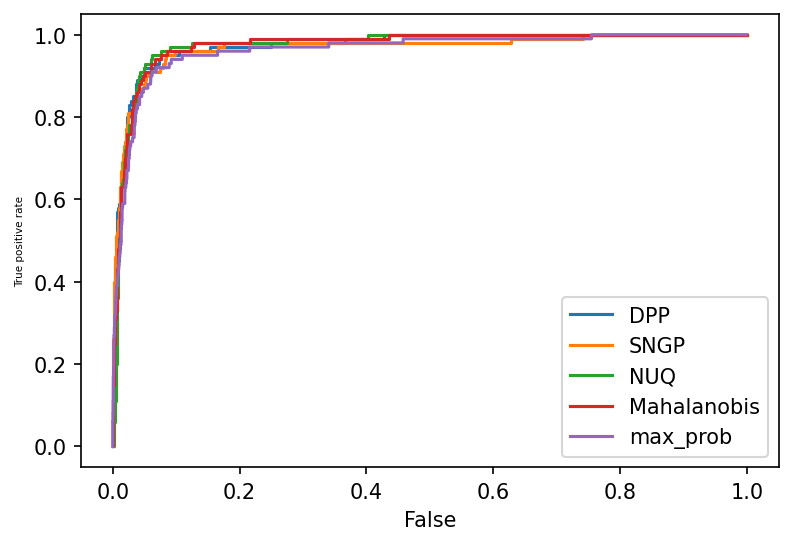

In [21]:
plt.figure(dpi=150)

fpr, tpr, _ = roc_curve(errors, dpp)
plt.plot(fpr, tpr, label='DPP')
print(f"DPP:", roc_auc_score(errors, dpp))

fpr, tpr, _ = roc_curve(errors, sngp)
plt.plot(fpr, tpr, label="SNGP")
print(f"SNGP:", roc_auc_score(errors, sngp))

fpr, tpr, _ = roc_curve(errors, nuq)
plt.plot(fpr, tpr, label="NUQ")
print(f"NUQ:", roc_auc_score(errors, nuq))

fpr, tpr, _ = roc_curve(errors, dist)
plt.plot(fpr, tpr, label="Mahalanobis")
print(f"Mahalanobis:", roc_auc_score(errors, dist))

max_prob = 1 - np.max(probabilities, axis=-1)
fpr, tpr, _ = roc_curve(errors, max_prob)
print(f"max_prob:", roc_auc_score(errors, max_prob))
plt.plot(fpr, tpr, label="max_prob")

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False")
plt.legend()